In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
grid_size = 8

Action in 2D:

$$
S_{latt}^E [U]= - \beta \sum_{n} \cos [\theta_{\mu\nu}(n)]
$$

($\mu < \nu$) with the angular representation of a plaquette

$$
\theta_{\mu\nu}(n) = \theta_{\mu}(n) + \theta_{\nu}(n+\mu) - \theta_{\mu}(n+\nu) - \theta_{\nu}(n).
$$

$\theta_{\mu}(n)\in [0,2\pi]$

In [4]:
def calc_plaquettes(theta):
    plaquettes = torch.zeros(theta.shape[0], grid_size, grid_size)
    plaquettes = (theta[:,0,:,:] + torch.roll(theta[:,1,:,:], -1, dims=1)
                  - torch.roll(theta[:,0,:,:], -1, dims=2) - theta[:,1,:,:])
    return plaquettes

In [5]:
def topological_charge(theta):
    plaquettes = calc_plaquettes(theta)
    plaquettes = (plaquettes+np.pi) % (2.*np.pi) - np.pi
    return torch.sum(plaquettes, dim=(1,2)) / (2.*np.pi)

In [6]:
def action(theta, beta=1.):
    plaquettes = calc_plaquettes(theta)
    return - beta * torch.sum(torch.cos(plaquettes), dim=(1,2))

In [7]:
# Generate initial configurations from a uniform distribution
def generate_initial_configs(n):
    # n ... batch size
    return torch.rand((n,2,grid_size,grid_size), device=device) * 2. * np.pi

Hybrid Monte Carlo

$$
Z = \int \prod_x \mathrm{d} \pi_x \prod_x \mathrm{d} \theta_x e^{- H(\pi,\theta)}
$$

$$
H(\pi,\theta) = \frac{1}{2} \sum_x \pi_x^2 + S(\theta)
$$

In [8]:
def hamiltonian(pi, theta, beta):
    return torch.sum(pi**2, dim=(1,2,3)) / 2. + action(theta, beta)

HMC step 1:

Choose new random momenta $\pi$

$$
P(\pi_i)\propto \exp(-\pi_i^2/2)
$$

In [9]:
def rand_momenta(n):
    return torch.randn((n, 2, grid_size, grid_size), device=device)

HMC step 2:

Solve Hamilton eqs

$$
\frac{\mathrm{d}}{\mathrm{d}\tau} \theta_x(\tau) = \frac{\partial}{\partial \pi_x} H(\pi(\tau),\theta(\tau))
= \pi_x
$$

$$
\frac{\mathrm{d}}{\mathrm{d}\tau} \pi_x(\tau) = -\frac{\partial}{\partial \theta_x} H(\pi(\tau),\theta(\tau))
= -\frac{\partial}{\partial \theta_x} S(\theta(\tau))
$$

Gradient of the action:

$$
\frac{\partial}{\partial \theta_{\mu}(n)}S_{latt}^E [\theta]= \beta \big( \sin(\theta_{\mu\nu}(n))
- \sin(\theta_{\mu\nu}(n-\nu)) \big)
$$

$$
\frac{\partial}{\partial \theta_{\nu}(n)}S_{latt}^E [\theta]= \beta \big( -\sin(\theta_{\mu\nu}(n))
+ \sin(\theta_{\mu\nu}(n-\mu)) \big)
$$

In [10]:
def action_grad(theta, beta):
    plaquettes = calc_plaquettes(theta)
    gradient = torch.zeros_like(theta)
    gradient[:,0,:,:] = beta * (torch.sin(plaquettes) - torch.sin(torch.roll(plaquettes, 1, dims=2)))
    gradient[:,1,:,:] = beta * (-torch.sin(plaquettes) + torch.sin(torch.roll(plaquettes, 1, dims=1)))
    return gradient

In [11]:
def hamilton_dynamics(pi, theta, tau, epsilon, beta):
    # Using the leap frog method
    n_steps = tau // epsilon
    theta = theta + epsilon / 2. * pi
    for i in range(int(n_steps)):
        pi = pi - epsilon * action_grad(theta, beta)
        theta = theta + epsilon * pi
    theta = theta - epsilon / 2. * pi
        
    return pi, theta

HMC step 3:

Acceptance step

$$
P_{accept} = \min(1, \exp(-\Delta H)) ,\: \Delta H = H(\pi',\theta') - H(\pi,\theta)
$$

In [12]:
def metropolis_step(pi_old, theta_old, pi_new, theta_new, beta):
    delta_h = hamiltonian(pi_new, theta_new, beta) - hamiltonian(pi_old, theta_old, beta)
    p_accept = torch.exp(-delta_h)
    theta = torch.zeros_like(theta_old)
    for i in range(theta_old.shape[0]):
        if torch.rand(1, device=device) < p_accept[i]:
            theta[i] = theta_new[i]
        else:
            theta[i] = theta_old[i]
    return theta

In [13]:
def hmc_alg(n, hmc_steps, beta, tau, epsilon=1e-4):
    theta = generate_initial_configs(n)
    pi = rand_momenta(n)
    tqdm_epoch = tqdm_notebook(range(hmc_steps))
    for i in tqdm_epoch:
        pi_new, theta_new = hamilton_dynamics(pi, theta, tau, epsilon, beta)
        theta = metropolis_step(pi, theta, pi_new, theta_new, beta)
        pi = rand_momenta(n)
    return theta

Topological charge evolution

In [14]:
def hmc_alg_hist(n, hmc_steps, beta, tau, epsilon=1e-4):
    theta = generate_initial_configs(n)
    pi = rand_momenta(n)
    tqdm_epoch = tqdm_notebook(range(hmc_steps))
    theta_hist = torch.zeros((n, hmc_steps, 2, grid_size, grid_size))
    for i in tqdm_epoch:
        pi_new, theta_new = hamilton_dynamics(pi, theta, tau, epsilon, beta)
        theta = metropolis_step(pi, theta, pi_new, theta_new, beta)
        theta_hist[:,i] = theta
        pi = rand_momenta(n)
    return theta_hist

### $\beta=1$:

In [15]:
hist = hmc_alg_hist(n=1, hmc_steps=2000, beta=1., tau=3., epsilon=1e-2)

  0%|          | 0/2000 [00:00<?, ?it/s]

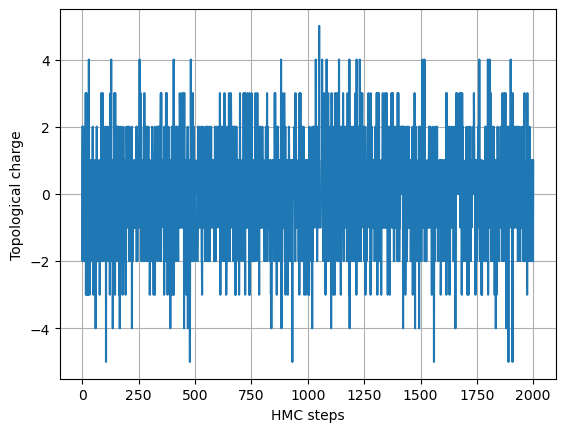

In [16]:
x = np.linspace(0,2000,2000)
plt.plot(x,topological_charge(hist[0]).cpu().numpy())
plt.ylabel('Topological charge')
plt.xlabel('HMC steps')
plt.grid()
plt.show()

In [17]:
hist = hmc_alg_hist(n=1000, hmc_steps=2000, beta=1., tau=3., epsilon=1e-2)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [18]:
topo_sus_hist = torch.zeros(hist.shape[1])
for i in range(hist.shape[1]):
    topo_sus_hist[i] = torch.mean(topological_charge(hist[:,i])**2)

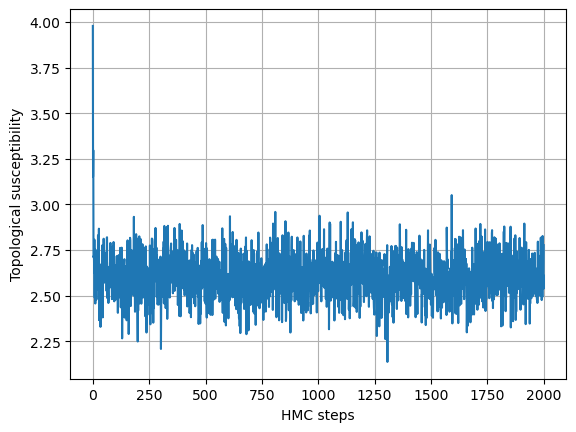

In [19]:
x = np.linspace(0,2000,2000)
plt.plot(x,topo_sus_hist.numpy())
plt.ylabel('Topological susceptibility')
plt.xlabel('HMC steps')
plt.grid()
plt.show()

#### Training samples:

In [20]:
training_samples = hmc_alg(n=10000, hmc_steps=2000, beta=1., tau=3., epsilon=1e-2).cpu()

  0%|          | 0/2000 [00:00<?, ?it/s]

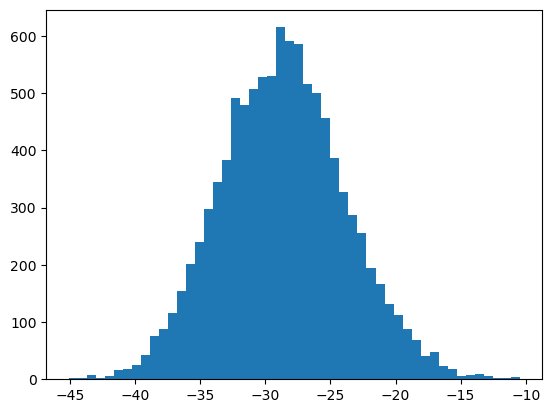

In [21]:
plt.hist(action(training_samples).numpy(), bins=50)
plt.show()

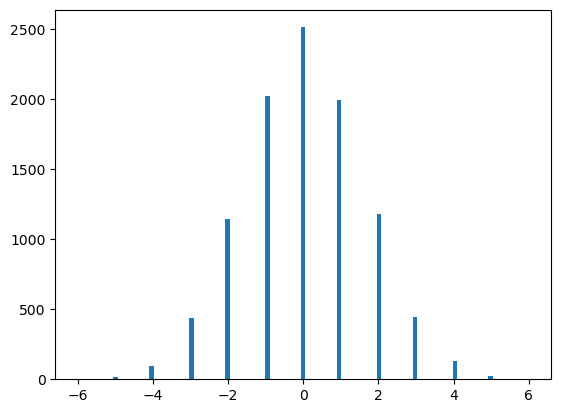

In [23]:
plt.hist(topological_charge(training_samples).numpy(), bins=101)
plt.show()

In [24]:
torch.save(training_samples, r'beta_1_grid_8.pt')

### $\beta=2$:

In [25]:
hist = hmc_alg_hist(n=1, hmc_steps=2000, beta=2., tau=3., epsilon=1e-2)

  0%|          | 0/2000 [00:00<?, ?it/s]

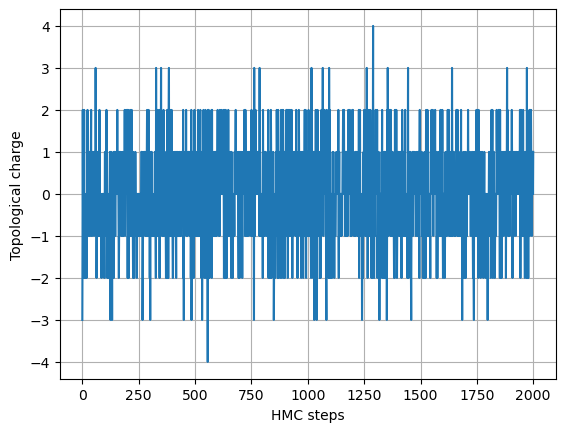

In [26]:
x = np.linspace(0,2000,2000)
plt.plot(x,topological_charge(hist[0]).cpu().numpy())
plt.ylabel('Topological charge')
plt.xlabel('HMC steps')
plt.grid()
plt.show()

In [27]:
hist = hmc_alg_hist(n=1000, hmc_steps=2000, beta=2., tau=3., epsilon=1e-2)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [28]:
topo_sus_hist = torch.zeros(hist.shape[1])
for i in range(hist.shape[1]):
    topo_sus_hist[i] = torch.mean(topological_charge(hist[:,i])**2)

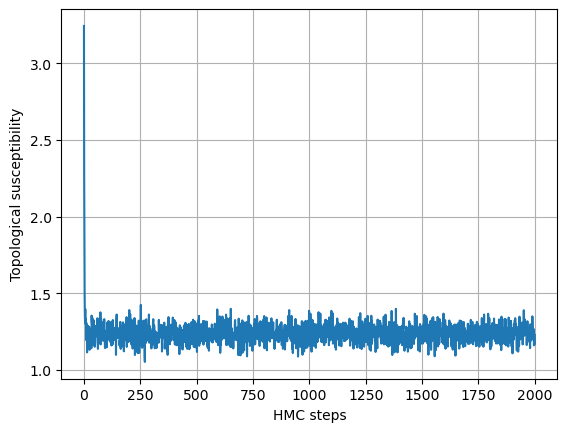

In [29]:
x = np.linspace(0,2000,2000)
plt.plot(x,topo_sus_hist.numpy())
plt.ylabel('Topological susceptibility')
plt.xlabel('HMC steps')
plt.grid()
plt.show()

#### Training samples:

In [30]:
training_samples = hmc_alg(n=10000, hmc_steps=2000, beta=2., tau=3., epsilon=1e-2).cpu()

  0%|          | 0/2000 [00:00<?, ?it/s]

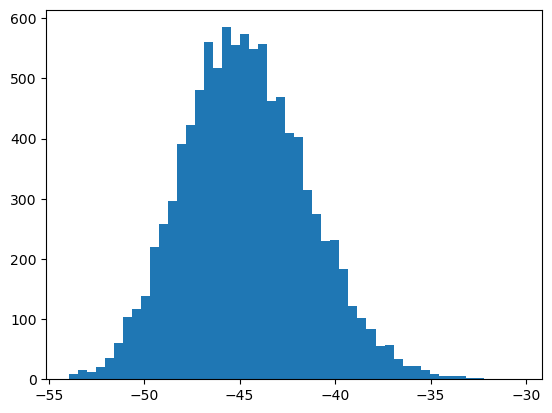

In [31]:
plt.hist(action(training_samples).numpy(), bins=50)
plt.show()

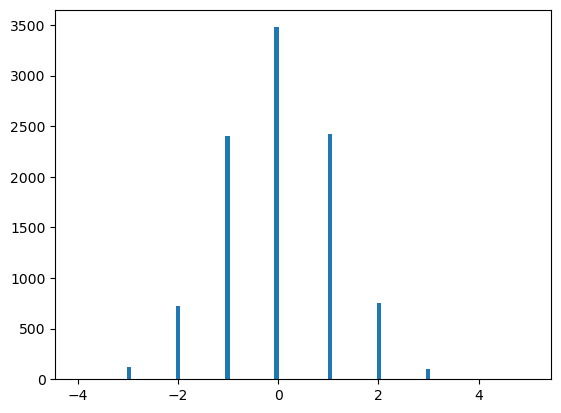

In [32]:
plt.hist(topological_charge(training_samples).numpy(), bins=101)
plt.show()

In [33]:
torch.save(training_samples, r'beta_2_grid_8.pt')

### Bigger grid for $\beta=2$

In [15]:
grid_size = 16

In [16]:
hist = hmc_alg_hist(n=1, hmc_steps=2000, beta=2., tau=3., epsilon=1e-2)

  0%|          | 0/2000 [00:00<?, ?it/s]

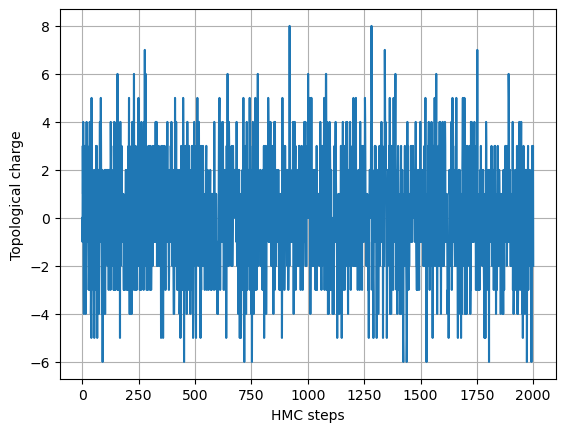

In [17]:
x = np.linspace(0,2000,2000)
plt.plot(x,topological_charge(hist[0]).cpu().numpy())
plt.ylabel('Topological charge')
plt.xlabel('HMC steps')
plt.grid()
plt.show()

In [18]:
hist = hmc_alg_hist(n=1000, hmc_steps=2000, beta=2., tau=3., epsilon=1e-2)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
topo_sus_hist = torch.zeros(hist.shape[1])
for i in range(hist.shape[1]):
    topo_sus_hist[i] = torch.mean(topological_charge(hist[:,i])**2)

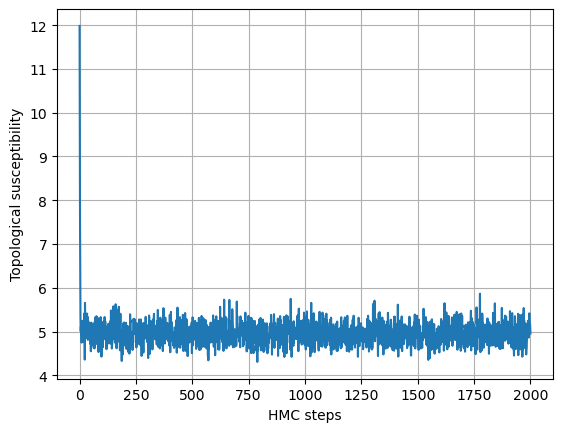

In [20]:
x = np.linspace(0,2000,2000)
plt.plot(x,topo_sus_hist.numpy())
plt.ylabel('Topological susceptibility')
plt.xlabel('HMC steps')
plt.grid()
plt.show()

#### Training samples:

In [21]:
training_samples = hmc_alg(n=10000, hmc_steps=2000, beta=2., tau=3., epsilon=1e-2).cpu()

  0%|          | 0/2000 [00:00<?, ?it/s]

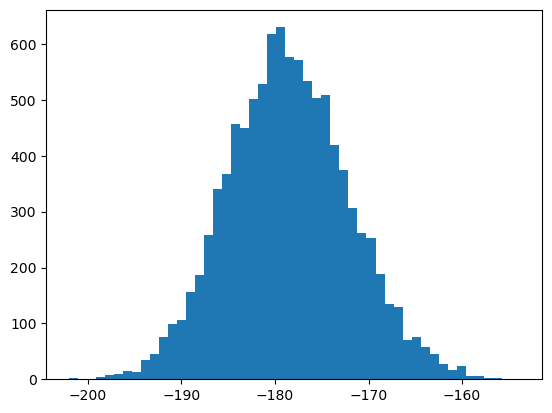

In [22]:
plt.hist(action(training_samples).numpy(), bins=50)
plt.show()

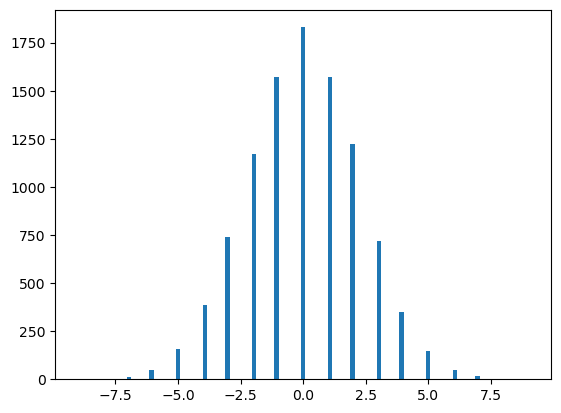

In [23]:
plt.hist(topological_charge(training_samples).numpy(), bins=101)
plt.show()

In [24]:
torch.save(training_samples, r'beta_2_grid_16.pt')

### $\beta=5$:

In [15]:
hist = hmc_alg_hist(n=1, hmc_steps=10000, beta=5., tau=3., epsilon=1e-2)

  0%|          | 0/10000 [00:00<?, ?it/s]

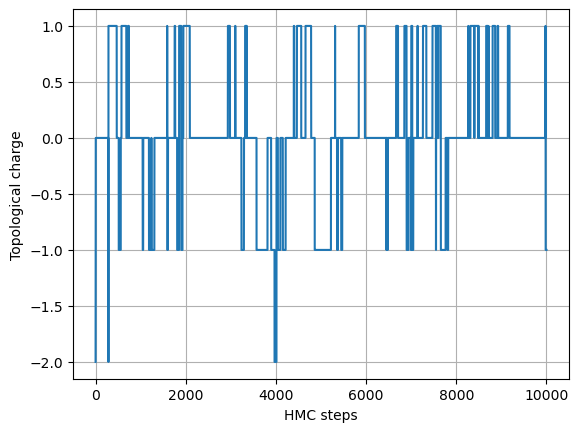

In [16]:
x = np.linspace(0,10000,10000)
plt.plot(x,topological_charge(hist[0]).cpu().numpy())
plt.ylabel('Topological charge')
plt.xlabel('HMC steps')
plt.grid()
plt.show()

In [17]:
hist = hmc_alg_hist(n=1000, hmc_steps=5000, beta=5., tau=3., epsilon=1e-2)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [18]:
topo_sus_hist = torch.zeros(hist.shape[1])
for i in range(hist.shape[1]):
    topo_sus_hist[i] = torch.mean(topological_charge(hist[:,i])**2)

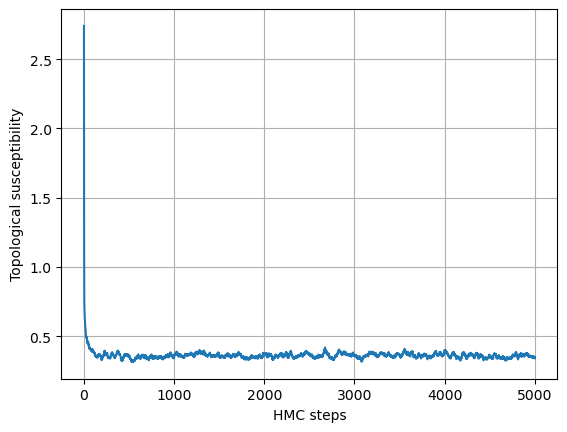

In [19]:
x = np.linspace(0,5000,5000)
plt.plot(x,topo_sus_hist.numpy())
plt.ylabel('Topological susceptibility')
plt.xlabel('HMC steps')
plt.grid()
plt.show()

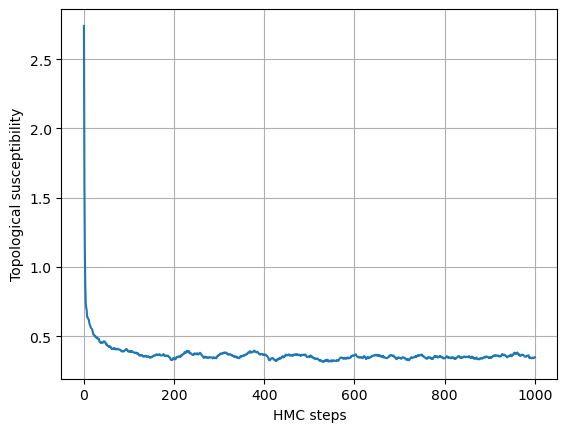

In [20]:
x = np.linspace(0,1000,1000)
plt.plot(x,topo_sus_hist[:1000].numpy())
plt.ylabel('Topological susceptibility')
plt.xlabel('HMC steps')
plt.grid()
plt.show()

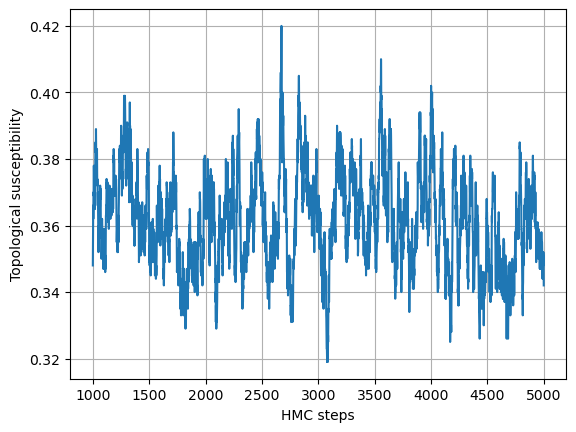

In [21]:
x = np.linspace(1000,5000,4000)
plt.plot(x,topo_sus_hist[1000:].numpy())
plt.ylabel('Topological susceptibility')
plt.xlabel('HMC steps')
plt.grid()
plt.show()

#### Training samples:

In [22]:
training_samples = hmc_alg(n=10000, hmc_steps=2000, beta=5., tau=3., epsilon=1e-2).cpu()

  0%|          | 0/2000 [00:00<?, ?it/s]

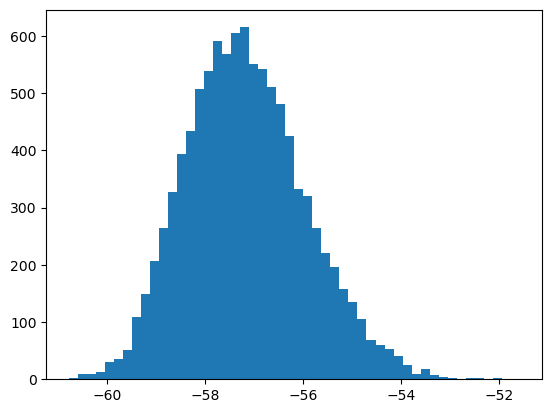

In [23]:
plt.hist(action(training_samples).numpy(), bins=50)
plt.show()

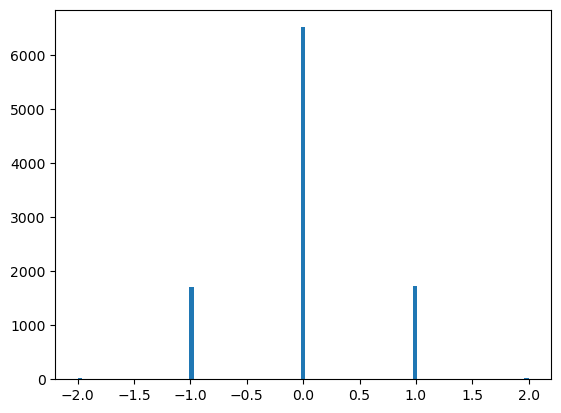

In [24]:
plt.hist(topological_charge(training_samples).numpy(), bins=101)
plt.show()

In [25]:
torch.save(training_samples, r'beta_5_grid_8.pt')


### $\beta=7$:

In [26]:
hist = hmc_alg_hist(n=1, hmc_steps=50000, beta=7., tau=3., epsilon=1e-2)

  0%|          | 0/50000 [00:00<?, ?it/s]

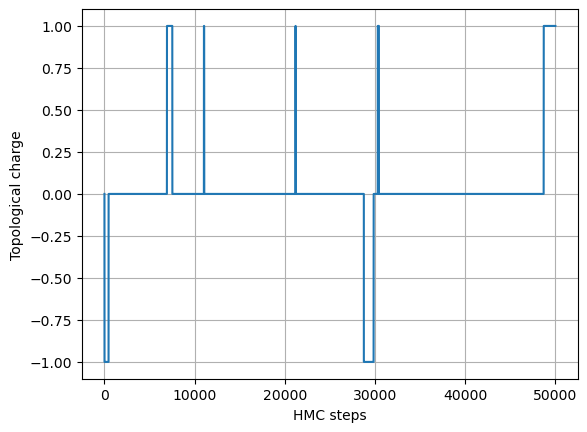

In [27]:
x = np.linspace(0,50000,50000)
plt.plot(x,topological_charge(hist[0]).cpu().numpy())
plt.ylabel('Topological charge')
plt.xlabel('HMC steps')
plt.grid()
plt.show()

In [16]:
hist = hmc_alg_hist(n=1000, hmc_steps=10000, beta=7., tau=3., epsilon=1e-2)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [17]:
topo_sus_hist = torch.zeros(hist.shape[1])
for i in range(hist.shape[1]):
    topo_sus_hist[i] = torch.mean(topological_charge(hist[:,i])**2)

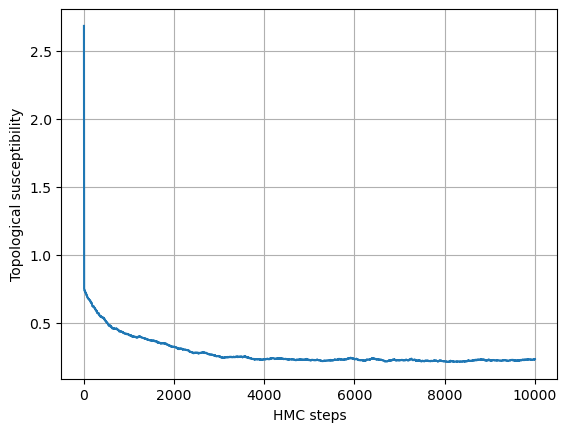

In [18]:
x = np.linspace(0,10000,10000)
plt.plot(x,topo_sus_hist.numpy())
plt.ylabel('Topological susceptibility')
plt.xlabel('HMC steps')
plt.grid()
plt.show()

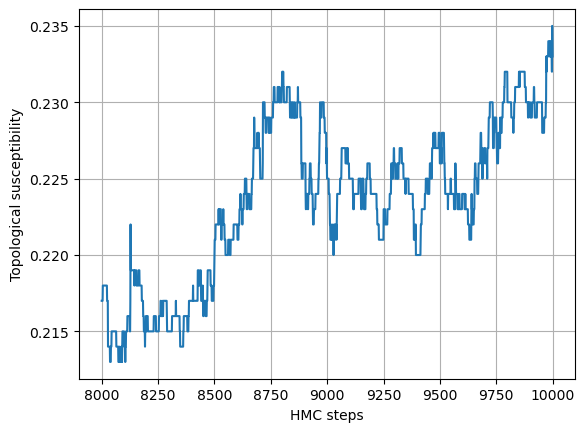

In [19]:
x = np.linspace(8000,10000,2000)
plt.plot(x,topo_sus_hist[8000:].numpy())
plt.ylabel('Topological susceptibility')
plt.xlabel('HMC steps')
plt.grid()
plt.show()

#### Training samples:

In [20]:
training_samples = hmc_alg(n=10000, hmc_steps=5000, beta=7., tau=3., epsilon=1e-2).cpu()

  0%|          | 0/5000 [00:00<?, ?it/s]

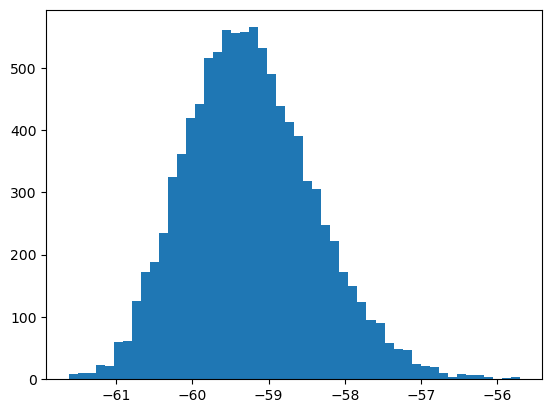

In [21]:
plt.hist(action(training_samples).numpy(), bins=50)
plt.show()

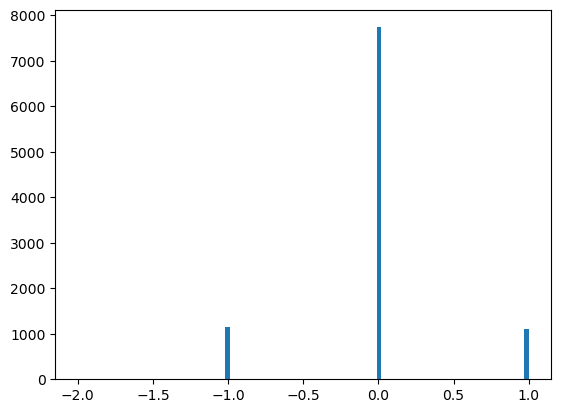

In [22]:
plt.hist(topological_charge(training_samples).numpy(), bins=101)
plt.show()

In [23]:
torch.save(training_samples, r'beta_7_grid_8.pt')
